<img src='../img/joint_school_banner_2.png' alt='training school and workshop on fire' align='center' width='100%'></img>

<br>

<hr>

# CAMS GFAS Fire Radiative Power

## About

The Copernicus Atmopshere Monitoring Service (CAMS) provides consistent and quality-controlled information related to air pollution and health and greenhouse gases. CAMS data consist of `global forecasts and analyses`, `global reanalyses`, `fire emissions` and `greenhouse gas flux inversions`. 

This notebook provides an introduction to the <a href='https://atmosphere.copernicus.eu/global-fire-emissions' target='_blank'>CAMS Global Fire Assimilation System (GFAS) global fire emissions data</a>. The CAMS Global Fire Assimilation System (GFAS) assimilates fire radiative power (FRP) observations from satellite-based sensors to produce daily estimates of wildfire and biomass burning emissions. It also provides information about injection heights derived from fire observations and meteorological information from the operational weather forecasts of ECMWF.

The GFAS data output includes spatially gridded `Fire Radiative Power (FRP)`, `dry matter burnt` and `biomass burning emissions` for a large set of chemical, greenhouse gas and aerosol species. Data are available globally on a regular latitude-longitude grid with horizontal resolution of 0.1 degrees from 2003 to present.

This notebook provides an introduction to the CAMS GFAS data and how the variable `Wildfire Radiative Power` can be used to monitor wildfires. The notebook examines the wildfires in southern Italy and Greece which occured in August 2021.

### Basic Facts
> **Spatial resolution**: `~10km` <br>
> **Spatial coverage**: `Global` <br>
> **Time step**:  `Daily data packaged in a monthly file` <br>
> **Data availability**: `since 2003`


### How to access the data

CAMS GFAS data are available in either `GRIB` or `netCDF` format. They can be downloaded from <a href='https://apps.ecmwf.int/datasets/data/cams-gfas/' target='_blank'>this ECMWF page</a>. 

Get more information in the <a href='https://atmosphere.copernicus.eu/sites/default/files/2018-05/CAMS%20%20Global%20Fire%20Assimilation%20System%20%28GFAS%29%20data%20documentation.pdf' target='_blank'>CAMS GFAS data documentation</a>.

<hr>

##### Load required libraries

In [1]:
%matplotlib inline
import os
import xarray as xr
import numpy as np
import netCDF4 as nc
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.cm import get_cmap
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

import warnings
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

##### Load helper functions

In [2]:
%run ../functions.ipynb

<hr>

## <a id="gfas_load"></a>1. Load and browse CAMS fire emissions data

### Open a CAMS GFAS netCDF file with `xarray`

CAMS GFAS fire emission data can be retrieved in either `GRIB` or `NetCDF` format. With the Python library `xarray` and the `open_dataset` function, we can easily read a single `NetCDF` file.

CAMS GFAS fire emission data are three dimensional data, with the dimensions `latitude`, `longitude` and `time`. The data file loaded has 31 time steps, from 1 August to 31 August 2021 and a global spatial coverage. The xarray dataset contains a data variable called `frpfire`.

In [3]:
gfas_frpfire_xr = xr.open_dataset('../../../eodata/lps_fire/cams/gfas/frp/2021/08/_grib2netcdf-webmars-public-svc-green-007-6fe5cac1a363ec1525f54343b6cc9fd8-cGY9R_.nc')
gfas_frpfire_xr

<xarray.Dataset>
Dimensions:    (longitude: 3600, latitude: 1800, time: 31)
Coordinates:
  * longitude  (longitude) float32 0.05 0.15 0.25 0.35 ... 359.8 359.9 360.0
  * latitude   (latitude) float32 89.95 89.85 89.75 ... -89.75 -89.85 -89.95
  * time       (time) datetime64[ns] 2021-08-01 2021-08-02 ... 2021-08-31
Data variables:
    frpfire    (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-02-15 11:56:28 GMT by grib_to_netcdf-2.24.0: grib_to_n...

### <a id='shift_europe'></a>Bring longitude coordinates onto a [-180,180] grid

The longitude values are on a [0,360] grid instead of a [-180,180] grid. 

You can assign new values to coordinates in an `xarray.Dataset`. You can do so with the `assign_coords()` function, which you can apply onto a `xarray.Dataset`. With the code below, you shift your longitude grid from [0,360] to [-180,180]. At the end, you sort the longitude values in an ascending order.

In [4]:
gfas_frpfire_xr_assigned = gfas_frpfire_xr.assign_coords(longitude=(((gfas_frpfire_xr.longitude + 180) % 360) - 180)).sortby('longitude')
gfas_frpfire_xr_assigned

<xarray.Dataset>
Dimensions:    (longitude: 3600, latitude: 1800, time: 31)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.9 -179.8 ... 179.8 179.9 180.0
  * latitude   (latitude) float32 89.95 89.85 89.75 ... -89.75 -89.85 -89.95
  * time       (time) datetime64[ns] 2021-08-01 2021-08-02 ... 2021-08-31
Data variables:
    frpfire    (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-02-15 11:56:28 GMT by grib_to_netcdf-2.24.0: grib_to_n...

<br>

A quick check of the longitude coordinates of the new `xarray.Dataset` shows you that the longitude values range now between [-180, 180].

In [5]:
gfas_frpfire_xr_assigned.longitude

<xarray.DataArray 'longitude' (longitude: 3600)>
array([-179.95001, -179.85   , -179.75   , ...,  179.75   ,  179.85   ,
        179.95001], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.9 -179.8 ... 179.8 179.9 180.0

We can select the data variable with `[]`, which gives us access to the DataArray and more parameter attributes. Thus, the dataset values are `wildfire radiative power` and the parameter unit is `W m**-2`.

In [6]:
frpfire = gfas_frpfire_xr_assigned['frpfire']
frpfire

<xarray.DataArray 'frpfire' (time: 31, latitude: 1800, longitude: 3600)>
[200880000 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.9 -179.8 ... 179.8 179.9 180.0
  * latitude   (latitude) float32 89.95 89.85 89.75 ... -89.75 -89.85 -89.95
  * time       (time) datetime64[ns] 2021-08-01 2021-08-02 ... 2021-08-31
Attributes:
    units:      W m**-2
    long_name:  Wildfire radiative power

## <a id='gfas_subset'></a>2. Create a geographical subset for Italy and Greece

Let's subset our data to Italy and Greece.

For geographical subsetting, you can make use of the function [generate_geographical_subset](./functions.ipynb#generate_geographical_subset). You can use `?generate_geographical_subset` to open the docstring in order to see the function's keyword arguments.

In [7]:
?generate_geographical_subset

Signature:
generate_geographical_subset(
    xarray,
    latmin,
    latmax,
    lonmin,
    lonmax,
    reassign=False,
)
Docstring:
Generates a geographical subset of a xarray.DataArray and if kwarg reassign=True, shifts the longitude grid 
from a 0-360 to a -180 to 180 deg grid.

Parameters:
    xarray(xarray.DataArray): a xarray DataArray with latitude and longitude coordinates
    latmin, latmax, lonmin, lonmax(int): lat/lon boundaries of the geographical subset
    reassign(boolean): default is False
    
Returns:
    Geographical subset of a xarray.DataArray.
File:      /tmp/ipykernel_251/3979307327.py
Type:      function


You can zoom into a region by specifying a `bounding box` of interest. Let us set the extent to Italy and Greece with the following bounding box information: 

In [8]:
lonmin=10
lonmax=30
latmin=35
latmax=45

Now, let us apply the function [generate_geographical_subset](./functions.ipynb#generate_geographcial_subset) to subset the `frpfire` xarray.DataArray. Let us call the new xarray.DataArray `frpfire_subset`.

In [9]:
frpfire_subset = generate_geographical_subset(xarray=frpfire, 
                                             latmin=latmin, 
                                             latmax=latmax, 
                                             lonmin=lonmin, 
                                             lonmax=lonmax)
frpfire_subset

<xarray.DataArray 'frpfire' (time: 31, latitude: 100, longitude: 200)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 10.05 10.15 10.25 10.35 ... 29.75 29.85 29.95
  * latitude   (latitude) float32 44.95 44.85 44.75 44.65 ... 35.25 35.15 35.05
  * time       (time) datetime64[ns] 2021-08-01 2021-08-02 ... 2021-08-31
Attributes:
    units:      W m**-2
    long_name:  Wildfire radiative power

Above, you see that the variable `frpfire_subset` has two attributes, `units` and `long_name`. Let us define variables for those attributes. The variables can be used for visualizing the data.

In [10]:
units = frpfire_subset.units
long_name= frpfire_subset.long_name

## <a id='gfas_vis'></a>3. Visualise CAMS GFAS fire emissions data

You can use the function [visualize_pcolormesh](../functions.ipynb#visualize_pcolormesh) to visualize the CAMS global fire emissions data with matplotlib's function `pcolormesh`. 

You can make use of the data attributes `units` and `long_name` and use them for plotting.

(<Figure size 1440x720 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'Wildfire radiative power 2021-08-05'}>)

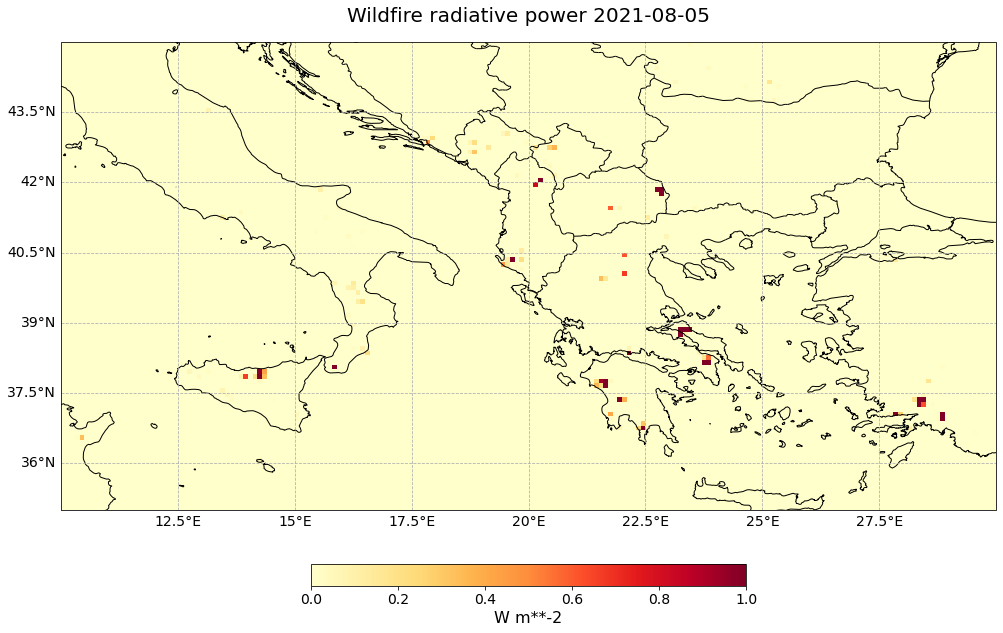

In [11]:
visualize_pcolormesh(data_array=frpfire_subset.isel(time=4).data,
                     longitude=frpfire_subset.longitude.data,
                     latitude=frpfire_subset.latitude.data,
                     projection=ccrs.PlateCarree(),
                     color_scale='YlOrRd',
                     unit=units,
                     long_name=long_name + ' ' + str(frpfire_subset.isel(time=4).time.data)[0:10],
                     vmin=0, 
                     vmax=1,
                     lonmin=lonmin,
                     lonmax=lonmax,
                     latmin=latmin,
                     latmax=latmax,
                     set_global=False)

**Return to the chapter:**
- [Surface impacts of wildfires](./01_surface_intro.ipynb#cams_gfas)

<hr>

<p style="text-align:right;">This project is licensed under the <a href="./LICENSE">MIT License</a> and is developed under a Copernicus contract.